In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M model, if you want 1.2B model you use gpt2-xl
sd_hf = model_hf.state_dict() # raw tensors

for k, v in sd_hf.items():
    print(k, v.shape) # key and value tensor shapes

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

from the first line above printed you can see the tensor size is `transformer.wte.weight torch.size([50257, 768])` , means `50257` tokens in GPT vocabulary and for each token we have `768` dimensional embedding. So each token is a string piece and each string peice is represented by a vector of size 768.

So `transformer.wte.weight torch.Size([50257, 768])` we have lookup table for **tokens**,and here `transformer.wpe.weight torch.Size([1024, 768])` we have lookup table for **positions**. Because **GPT-2 has a maximum sequence length of 24**, we have upto 1024 positions that each token can be attending to in the past and everyone of those postions in GPT-2 has fixed vector of 768 that is learned through optimization, and so this position embedding and the token embedding. So everything else is just weights and biases of this transformer.

In [3]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

Above: take the positional embeddings and just flatten it out and we can take them and plot them

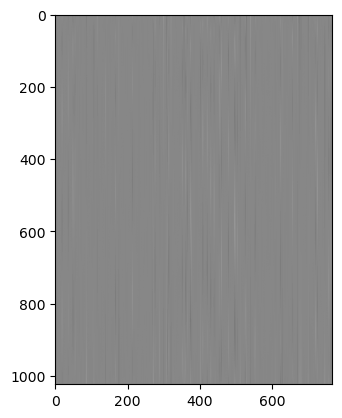

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")
plt.show()

You can see it has structure, every coulmn in this visualization is different, fixed absolute position on the range from 0 to 1024 and each row is the represesntation of that position. It has structure because, these positional embeddings end up learning these sinusoids, cosines to represent each of these positions and each row here stands in for that position and is processed by the Transformer to recover all the relative positions, realize which token is where and attend to them depending on their position and not just on their content.

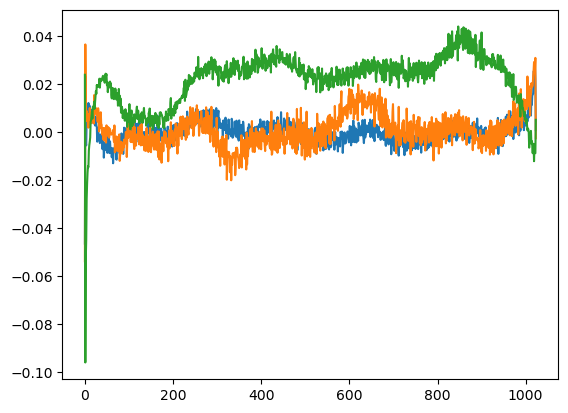

In [5]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])
plt.show()

If we look into invidual columns like these and grab some of the column and plot, here we are focusing on every single channel and we're looking at what that channel is doing from 0 to 1024. We can see some the channels basically respond more or less to the different parts of th eposition spectrum, for e.g. the `BROWN` channel llikes to fire everything after `300` upto `800` and has a sharp drop of near `0`. You can see the embeddings are a bit jagged and a bit NOISY, you can say that the this model is not trained fully. The more you train the model, the more you will smooth this out.

This position embedding table is initialized randomly at the beginning of the training. In the original transformer paper the position embeddings are FIXED to sinusoids and cosines of different frequencies. **But in GPT2, these are just parameters and are trained from scratch, just like any other parameter.**The y recover these sinusoids like features during optimization.

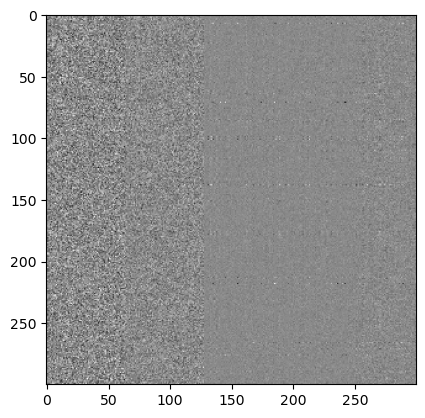

In [6]:
# looking at any other matrices
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")
plt.show()

In [7]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so I can write things that are easy to understand with help of my programming language."\n\nHowever, this'},
 {'generated_text': "Hello, I'm a language model, you understand me, so when you're doing something you've written in a C# IDE, you know it"},
 {'generated_text': "Hello, I'm a language model, but I like to use the language model so much that I had to write a parser instead of a parser."},
 {'generated_text': 'Hello, I\'m a language model, I\'m not a programming language. You know, I do need to build my language, at least." He'},
 {'generated_text': "Hello, I'm a language model, I use Python, and I'm very familiar with Python and Python-ish scripting. I'm also pretty familiar"}]

we have loaded the weights from AI using the HuggingFace Transformers, we cannot get all the raw weights, but we can get the pipeline and sample from it. PREFIX: `Hello, I'm a language model,` and then we are sampling 30 tokens `max_length=30`, and getting 5 sequence with `num_return_sequences=5`, making a human readable document there are other languages.

### Names of the block and which one they are

**Token Embedding** (`transformer.wte.weight torch.Size([50257, 768])`)


<img src="token-embedding.png" alt="image" width="150">

**Positional Embedding** (`transformer.wpe.weight torch.Size([1024, 768])`)


<img src="positional-embedding.png" alt="image" width="150">


**Hidden Block** 
    ```transformer.h.0.ln_1.weight torch.Size([768])
        transformer.h.0.ln_1.bias torch.Size([768])
        transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
        transformer.h.0.attn.c_attn.bias torch.Size([2304])
        transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
        transformer.h.0.attn.c_proj.bias torch.Size([768])
        transformer.h.0.ln_2.weight torch.Size([768])
        transformer.h.0.ln_2.bias torch.Size([768])
        transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
        transformer.h.0.mlp.c_fc.bias torch.Size([3072])
        transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
        transformer.h.0.mlp.c_proj.bias torch.Size([768])```

<img src="hidden_layer.png" alt="image" width="150">

In [8]:
# tiny shakespear dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first thousand characters
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [9]:
# compression ratio of the tokenizer has a ratio of 3:1
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [11]:
import torch
buf = torch.tensor(tokens[:24+1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [ ]:
print(sd_hf["lm_head.weight"].shape) # giving token embedding
print(sd_hf["transformer.wte.weight"].shape) # this one is taking 768 embeddings and trying to upscale that to 50257

torch.Size([50257, 768])
torch.Size([50257, 768])


In [ ]:
# If you compare in pytorch this is element wise equality here aswell
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()


tensor(True)

In [ ]:
# If we look at the data pointer than  then both are same as well
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())
# So these shape not only have same shape and same elements they're 
# actually pointing to identical tensors
# this is a common weight tying scheme that comes from the original
# attnetion is all you need paper
# if you see in the Attention is all you need paper's 3.4 Embeddings
# and Softmax section "We share the same weight matrix between the 
# two embedding layers and the pre-softmax linear transformation 
# similar to [30]Rico Sennrich, Barry Haddow, and Alexandra Birch. Neural machine translation of rare words with subword units. arXiv preprint arXiv:1508.07909, 2015."
# Generally the idea for this sharing of weights is in [30]
# " We call U the input embeddings, and V the output embedding. In both matrices
# we except rows that correspond to similar words to be similar: for the input embedding
# we would like the networj to react similarly to the synonyms, while in the output embedding
# we would like the scores of words that are interchangeable to the similar."

# Also actually you can see that you want these two matrices (input and output embedding)
# to behave similar in the following sense. If two tokens are similar in the following sense i.e.
# if two token behave similar semantically, oresumably you would expect that they are nearby
# in the token embedding space.
# Similarly for output embedding, if two tokens are similar semantically the you'd expect
# them to get the same probabilities at the output of a transformer

# So both positions in the Transformer at the very bottom and at the top have this property that
# similar tokens should have similar embeddings or similary weights

# So this was adopted in the attention is all you need paper
# Also adapted in GPT-2 Paper

4774376243456
4774376243456


In [16]:
# Currently he is not sharing wte in the pytorch code
# but in hugging face model it is shared what we saw above


In [18]:
# The GPT-2 Paper and GPT-3 Paper donot explicitly say how
# do they initialize the weights
# They have initialized using a standard deviation of 0.02 
# and randome notmal initializer 

"""From the GPT-2 Paper: A modified initialization which accounts for the
        accumulation on the residual path with the model depth is used. We scale the
        weights of the residual layers at initialization by a factor of 1/sqrt(N)\
        where N is the number of residual layers"""

# Here is what they mean
# Standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += torch.randn(768) # normal 1 deviation standard devaiation

print(x.std())
# This means that if you start out with zeros in your residual stream
# every single block of the residual netowrk contributes some amount and get add
# variance of the activation at the residual stream grows.

# Thats why the scaling factor they use in GPT-2 paper 
# which is 1/sqrt(N) exactly compensates for that growth

# so with scaling
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += n**-0.5*torch.randn(768) # normal 1 deviation standard devaiation

print(x.std())


tensor(10.3244)
tensor(1.0125)


In [ ]:
import torch 

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)

torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])
# L = 1/4 * [
#       (y[0]-yhat[0])**2 +
#       (y[1]-yhat[1])**2 +
#       (y[2]-yhat[2])**2 +
#       (y[3]-yhat[3])**2
#       ]
# NOTE: the "normalizer" of 1/4 is lost

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


In [ ]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <----> SUM in loss
# i.e. we instead get:
# L0 = (y[0] - yhat[0])**2
# L1 = (y[1] - yhat[1])**2
# L2 = (y[2] - yhat[2])**2
# L3 = (y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the `normalizer` of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i]) / 4 # <== this is the normalizer  
    # if you donot have 1/4 then grad is very high
    loss.backward() # this is not the same because the mean squared error is lost
print(net[0].weight.grad.view(-1)[:10])

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


Min Train Loss: 3.158252
Min Validation Loss: 3.3449
Max Hellaswag eval: 0.2741


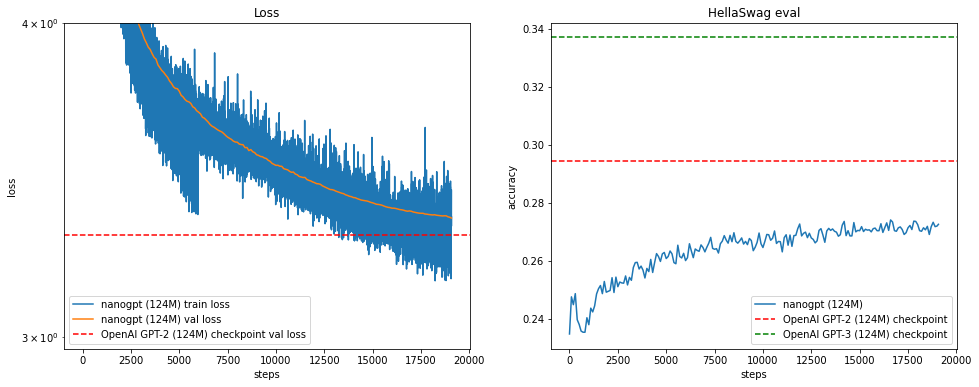

In [2]:
# visualizing the log file
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("/home/uns991/work/gpt_quant/gpt2_karpathy/log124M_10B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

#### Results on GPT-2 with fineweb_100B dataset
On 10B params 124M is not able to do well. We need to train it on bigger dataset.

Lets try on sample-100BT (fineweb's 100 Billion token dataset)

Min Train Loss: 2.551605
Min Validation Loss: 3.0594
Max Hellaswag eval: 0.3176


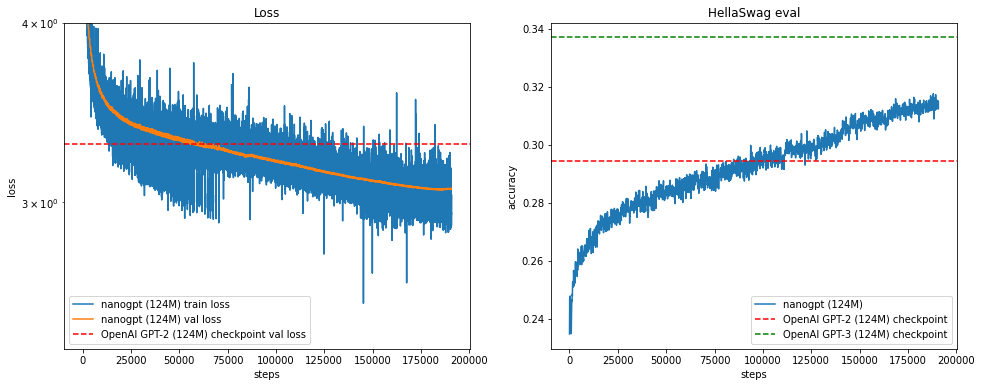

In [3]:
# visualizing the log file
sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("/home/uns991/work/gpt_quant/gpt2_karpathy/log124M_100B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))